In [311]:
# импорт библиотек
import warnings
warnings.simplefilter('ignore', UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import spacy
import numpy as np

from tqdm import tqdm

In [802]:
pd.set_option('display.max_rows', 10)

In [456]:
sns.set_style('darkgrid')

In [9]:
# импорт данных
ozon_text = pd.read_excel('Список характеристик Ozon c ID.xlsx')\
    .drop_duplicates(subset='name')\
    .reset_index(drop=True)\
    ['name']\
    .apply(lambda x: x.lower())\
    .to_list()
    
wb_text = pd.read_excel('Список характеристик WB с ID.xlsx')\
    .drop_duplicates(subset='name')\
    .reset_index(drop=True)\
    ['name']\
    .apply(lambda x: x.lower())\
    .to_list()

In [2]:
# загрузка языкового пакета
nlp = spacy.load('ru_core_news_lg')

## Первая итерация
Предобработка данных за исключением изменения типа данных не производится

In [485]:
# ссоздание списка из объектов spacy
ozon = list(nlp.pipe(ozon_text))
wildb = list(nlp.pipe(wb_text))

In [664]:
def get_similarity(oz, wb):

    df = pd.DataFrame()

    i = 0

    for o in tqdm(oz):
        
        l = np.array([o.similarity(w) for w in wb])
        
        temp_df = pd.DataFrame({'ozon': ozon[i].text,
                                'wb': wildb[l.argmax()].text,
                                'similarity': max(l)},
                               index=[i])
        
        i += 1
        
        df = pd.concat([df, temp_df])
        
    return df

## Вторая итерация
Производится обработка данных: убираются стоп-слова, проводится лемматизация токенов, убирается пунктуация

In [737]:
def text_preprocessing_2(l):
    res_list = []
    for word in l:
        result = [token.lemma_ for token in word if token.text not in nlp.Defaults.stop_words and token.is_punct == False and token.vector_norm != 0 and word.vector_norm != 0]
        res_list.append(nlp(" ".join(result)))
    return res_list

In [738]:
lemma_oz, lemma_wb = text_preprocessing_2(ozon), text_preprocessing_2(wildb)

In [739]:
lemma_res = get_similarity(lemma_oz, lemma_wb)

100%|██████████| 7158/7158 [03:19<00:00, 35.95it/s]


## Третья итерация
Проводится обработка данных: убираются стоп-слова, убирается пунктуация, в результат записываются только прилагательные и существительные

In [740]:
def text_preprocessing_3(l):
    res_list = []
    for word in l:
        result = [token.lemma_ for token in word if token.text not in nlp.Defaults.stop_words and token.is_punct == False and token.pos_ in ['ADJ', 'NOUN'] and token.vector_norm != 0 and word.vector_norm != 0]
        res_list.append(nlp(" ".join(result)))
    return res_list

In [741]:
third_oz, third_wb = text_preprocessing_3(ozon), text_preprocessing_3(wildb)

In [742]:
third_res = get_similarity(third_oz, third_wb)

100%|██████████| 7158/7158 [03:14<00:00, 36.78it/s]


## Четвёртая итерация
Проводится обработка данных: убираются стоп-слова, убирается пунктуация, в результат записываются только прилагательные, существительные и дополнения.

In [743]:
def text_preprocessing_4(l):
    res_list = []
    for word in l:
        result = [token.lemma_ for token in word if token.text not in nlp.Defaults.stop_words and token.is_punct == False and token.dep_ in ['ROOT', 'amod', 'nmod'] and token.vector_norm != 0 and word.vector_norm != 0]
        res_list.append(nlp(" ".join(result)))
    return res_list

In [744]:
fourth_oz, fourth_wb = text_preprocessing_4(ozon), text_preprocessing_3(wildb)

In [745]:
fourth_res = get_similarity(fourth_oz, fourth_wb)

100%|██████████| 7158/7158 [03:15<00:00, 36.64it/s]


In [803]:
fourth_res.to_excel('almost_ready_res.xlsx')

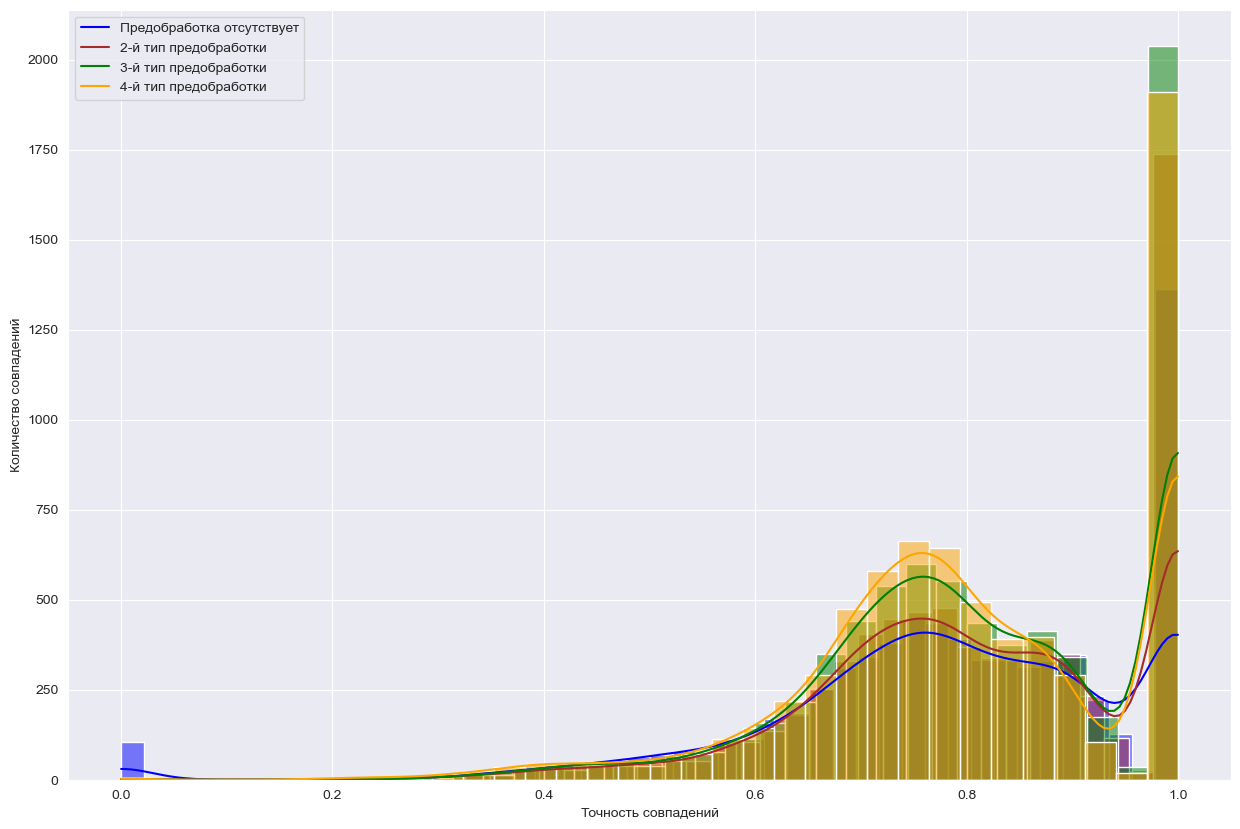

In [746]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x='similarity', color='blue', ax=ax, alpha=0.5, kde=True)
sns.histplot(data=lemma_res, x='similarity', color='brown', ax=ax, alpha=0.5, kde=True)
sns.histplot(data=third_res, x='similarity', color='green', ax=ax, alpha=0.5, kde=True)
sns.histplot(data=fourth_res, x='similarity', color='orange', ax=ax, alpha=0.5, kde=True)
plt.xlabel('Точность совпадений')
plt.ylabel('Количество совпадений')
plt.legend(['Предобработка отсутствует', '2-й тип предобработки', '3-й тип предобработки', '4-й тип предобработки'])

In [804]:
test = nlp('тип квадрокоптера')

In [818]:
for token in test:
    print('{:<20}{:<10}{:<10}{:<10}'.format(token.text, token.ent_type_, token.tag_, token.pos_, token.dep_))

тип                           NOUN      NOUN      
квадрокоптера                 NOUN      NOUN      


In [819]:
nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']